In [1]:
import os
import torch
from torch.utils import data
from dataset import Dataset_T
from model.SSN import create_ssn_net, Loss, SSN
from PIL import Image
import scipy
from model.util import get_spixel_image
import sys
import numpy as np
import argparse
import imageio
import scipy.io as scio
import matplotlib.pyplot as plt
# sys.path.append('')
from connectivity import enforce_connectivity
os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def compute_spixels(root, num_spixel, num_steps, pre_model, out_folder):

    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
        # os.makedirs(out_folder+'png')
        # os.makedirs(out_folder + 'mat')

    dtype = 'test'
    dataloader = data.DataLoader(Dataset_T( root = root, num_spixel=num_spixel),
                        batch_size=1, shuffle=False, num_workers=1)
    
    model = create_ssn_net(num_spixels=num_spixel, num_iter=num_steps, num_spixels_h=10, num_spixels_w=10, dtype=dtype, ssn=0)
    model = torch.nn.DataParallel(model)
    
    if pre_model is not None:
        if torch.cuda.is_available():
            model.load_state_dict(torch.load(pre_model))
        else:
           model.load_state_dict(torch.load(pre_model, map_location='cpu'))
    else:
        raise ('no model')
    criten = Loss()
    device = torch.device('cpu')
    if torch.cuda.is_available():
        model.cuda()
        device = torch.device('cuda')
    outputs = []
    for iter, [inputs, num_h, num_w, init_index, cir_index, p2sp_index_, invisible, file_name] in enumerate(dataloader):
        with torch.no_grad():
            img = inputs['img'].to(device)
            label = inputs['label'].to(device)
            problabel = inputs['problabel'].to(device)
            num_h = num_h.to(device); num_w = num_w.to(device)
            init_index = [x.to(device) for x in init_index]
            cir_index = [x.to(device) for x in cir_index]
            p2sp_index_ = p2sp_index_.to(device)
            invisible = invisible.to(device)

            recon_feat2, recon_label, new_spix_indices = model(img, (p2sp_index_, invisible, init_index, cir_index, problabel, num_h,
                                             num_w, device))
            # loss, loss_1, loss_2 = criten(recon_feat2, img, recon_label, label)
            # print(loss)
            given_img = np.asarray(Image.open(file_name[0]))
            h, w = given_img.shape[0], given_img.shape[1]
            new_spix_indices = new_spix_indices[:, :h, :w].contiguous()
            
            
            spix_index = new_spix_indices.cpu().numpy()[0]
            spix_index = spix_index.astype(int)
            outputs.append(spix_index)

            if enforce_connectivity:
                segment_size = (given_img.shape[0] * given_img.shape[1]) / (int(num_h*num_w) * 1.0)
                min_size = int(0.06 * segment_size)
                max_size = int(3 * segment_size)
                spix_index = enforce_connectivity(spix_index[np.newaxis, :, :], min_size, max_size)[0]
            # given_img_ = np.zeros([spix_index.shape[0], spix_index.shape[1], 3], dtype=np.int)
            # h, w = given_img.shape[0], given_img.shape[1]
            # given_img_[:h, :w] = given_img

            print("output =", spix_index.shape)
            counter_image = np.zeros_like(given_img)
            counter_image = get_spixel_image(counter_image, spix_index)
            spixel_image = get_spixel_image(given_img, spix_index)

            imgname = file_name[0].split('/')[-1][:-4]
            out_img_file = out_folder + imgname + '_bdry_.jpg'
            imageio.imwrite(out_img_file, spixel_image)
            # out_file = out_folder + imgname + '.npy'
            # np.save(out_file, spix_index)

            # validation code only for sp_pix 400
            # out_file_mat = out_folder + 'mat/'+ imgname + '.mat'
            # scio.savemat(out_file_mat, {'segs': spix_index})

            # out_count_file = out_folder + 'png/' + imgname + '.png'
            # imageio.imwrite(out_count_file, counter_image)
            print(iter)
    return outputs

class ARGS:
    def __init__(self):
        self.n_spixels=100
        self.num_steps=10
        self.result_dir='./results/pix/'
        self.pre_dir='./45000_0.527_model.pt'
        self.root = 'data'
args = ARGS()


In [2]:
# outputs = compute_spixels(args.root, args.n_spixels, args.num_steps,args.pre_dir, args.result_dir)

In [3]:

def imgtensor2np(img):
    return img.permute(1,2,0).detach().cpu().numpy()
def to_device(args, device):
    args_out = []
    for arg in args:
        if isinstance(arg, list):
            arg = [ elem.to(device, torch.float64) for elem in arg ]
        else:
            arg = arg.to(device, torch.float64)
        args_out.append(arg)
    return args_out

def segmentfromLabels(given_img, new_spix_indices, num_h,num_w):
    h, w = given_img.shape[0], given_img.shape[1]
    new_spix_indices = new_spix_indices[:, :h, :w].contiguous()
    spix_index = new_spix_indices.cpu().numpy()[0]
    spix_index = spix_index.astype(int)

    if enforce_connectivity:
        segment_size = (given_img.shape[0] * given_img.shape[1]) / (int(num_h*num_w) * 1.0)
        min_size = int(0.06 * segment_size)
        max_size = int(3 * segment_size)
        spix_index = enforce_connectivity(spix_index[np.newaxis, :, :], min_size, max_size)[0]

    return  get_spixel_image(given_img, spix_index)


In [4]:
# root, num_spixel, num_steps, pre_model, out_folder = args.root, args.n_spixels, args.num_steps,  args.pre_dir ,args.result_dir

root, num_spixel, num_steps, pre_model, out_folder = args.root, args.n_spixels, args.num_steps,  None ,args.result_dir


dataloader = data.DataLoader(Dataset_T( root = root, num_spixel=num_spixel),
                    batch_size=1, shuffle=False, num_workers=1)


SSNLayer = SSN(args.pre_dir, spixel_size=(5,5),dtype = 'layer', device = device)

for i, [inputs, num_h, num_w, init_index, cir_index, p2sp_index_, invisible, file_name] in enumerate(dataloader):
    with torch.no_grad():
        # img, label, problabel, num_h, num_w, init_index, cir_index, p2sp_index_,invisible\
        #      = to_device([inputs['img'],inputs['label'],inputs['problabel'], num_h, num_w, init_index, cir_index, p2sp_index_,invisible], device)
        img = inputs['img'].to(device)
        label = inputs['label'].to(device)
        problabel = inputs['problabel'].to(device)
        num_h = num_h.to(device); num_w = num_w.to(device)
        init_index = [x.to(device) for x in init_index]
        cir_index = [x.to(device) for x in cir_index]
        p2sp_index_ = p2sp_index_.to(device)
        invisible = invisible.to(device)

        # obtain the features and Superpixel labels
        features,new_spix_indices = SSNLayer(img, (p2sp_index_, invisible, init_index, cir_index, problabel, num_h,
                                            num_w, device))                                            
 

        given_img = np.asarray(Image.open(file_name[0]))
        segmented_img = segmentfromLabels(given_img, new_spix_indices,num_h,num_w)
        
        if i == 4:
            break    

(51,)


In [24]:
# features.shape, 



im = imgtensor2np(img[:,:3][0])



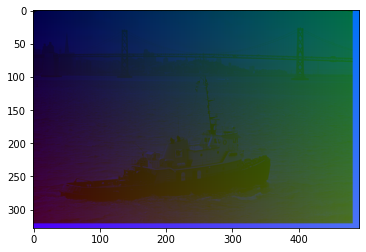

In [5]:
# len(np.unique(new_spix_indices.data.cpu().numpy()))

96

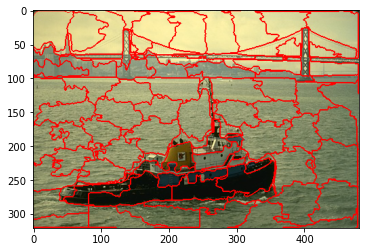

In [7]:
plt.imshow(segmented_img)

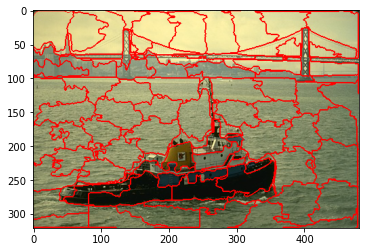

In [6]:

plt.imshow(segmented_img)

In [6]:

# Iterate all colors in mask
for color in np.unique(mask):

    # Color 0 is assumed to be background or artifacts
    if color == 0:
        continue

    # Determine bounding rectangle w.r.t. all pixels of the mask with
    # the current color
    x, y, w, h = cv2.boundingRect(np.uint8(mask == color))

    # Draw bounding rectangle to color image
    out = cv2.rectangle(img.copy(), (x, y), (x+w, y+h), (0, int(color), 0), 2)

    # Show image with bounding box
    cv2.imshow('img_' + str(color), out)

# Show mask
cv2.imshow('mask', mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

(torch.Size([1, 5, 328, 492]), torch.Size([1, 50, 328, 492]))

# AttentionUNet

In [30]:
from model.AttentionUNet import ResUnetPlusPlus
net = ResUnetPlusPlus()

ValueError: too many values to unpack (expected 2)